In [12]:
import matplotlib.pyplot as plt

import numpy as np

In [13]:
outputs = []
for k in [0, 1, 2, 3]:
    output = np.load(f'../../logs/probe_tacotron2_articulatory_features/scores/probe_layer_{k}.npz')
    outputs.append(dict(output))

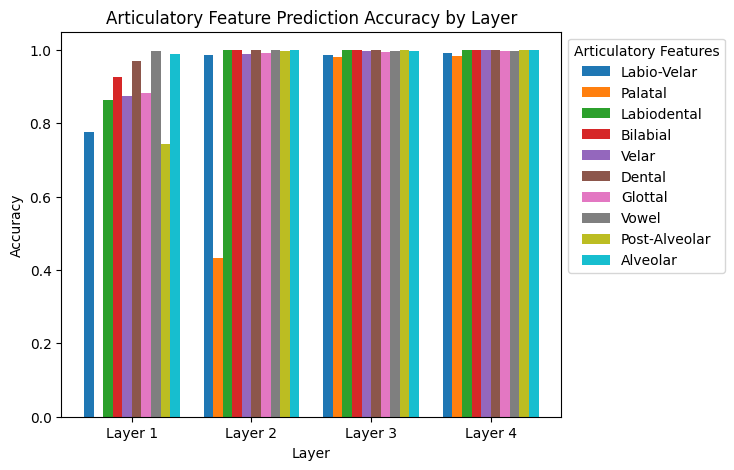

In [14]:
layer_accuracies = outputs

# 조음 특성 목록 (각 레이어의 key 순서에 따라 정렬되어야 함)
articulatory_features = ['Labio-Velar', 'Palatal', 
    'Labiodental', 'Bilabial', 'Velar', 'Dental', 
    'Glottal', 'Vowel', 'Post-Alveolar', 'Alveolar']

# 각 레이어별로 데이터 추출
data_per_feature = {feature: [] for feature in articulatory_features}
for layer_accuracy in layer_accuracies:
    for feature in articulatory_features:
        data_per_feature[feature].append(layer_accuracy[feature].item())  # np.array로 저장된 값을 float으로 변환

# 각 조음 특성별로 성능 비교
num_layers = len(layer_accuracies)
index = np.arange(num_layers)
bar_width = 0.08  # 바의 너비

fig, ax = plt.subplots(figsize=(8, 5))
for i, (feature, data) in enumerate(data_per_feature.items()):
    ax.bar(index + i*bar_width, data, bar_width, label=feature)

ax.set_xlabel('Layer')
ax.set_ylabel('Accuracy')
ax.set_title('Articulatory Feature Prediction Accuracy by Layer')
ax.set_xticks(index + bar_width / 2 * (len(articulatory_features) - 1))
ax.set_xticklabels([f'Layer {i+1}' for i in range(num_layers)])
# ax.legend()

# 범례를 오른쪽으로 이동
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title='Articulatory Features')

# 차트의 오른쪽 여백을 범례에 맞게 조정
plt.subplots_adjust(right=0.75)

plt.show()

In [33]:
outputs = []
for n in range(1, 31):
    output = np.load(f'../../logs/probe_tacotron2_articulatory_features/scores/probe_selected_{n}.npz')
    outputs.append(dict(output))

FileNotFoundError: [Errno 2] No such file or directory: '../../logs/probe_tacotron2_articulatory_features/scores/probe_selected_28.npz'

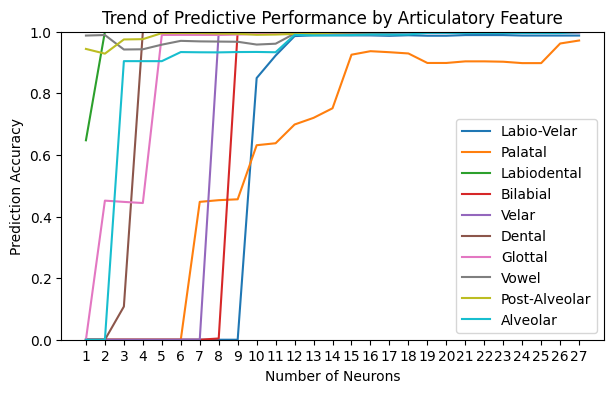

In [36]:
results = outputs

# Extract performance values for overall and for each feature
# overall_performance = [result['__OVERALL__'] for result in results]
# 조음 특성 목록 (각 레이어의 key 순서에 따라 정렬되어야 함)
articulatory_features = ['Labio-Velar', 'Palatal', 
    'Labiodental', 'Bilabial', 'Velar', 'Dental', 
    'Glottal', 'Vowel', 'Post-Alveolar', 'Alveolar']
performance_by_feature = {feature: [result[feature] for result in results] for feature in articulatory_features}


# 전체 성능과 각 특성에 대해 한 개의 그래프에 그립니다
fig, ax = plt.subplots(figsize=(7, 4))

# 전체 성능을 그래프로 그립니다 (선택적)
# ax.plot(['Top 5', 'Top 10', 'Top 15', 'Top 20', 'Top 25', 'Top30'], overall_performance, marker='o', label='__OVERALL__', linewidth=2, linestyle='--')

# 각 특성에 대한 성능을 그래프로 그립니다
for feature, performance in performance_by_feature.items():
    # ax.plot([f'Top {i + 1}' for i in range(len(performance_by_feature['Labio-Velar']))], performance, label=feature)
    ax.plot([f'{i + 1}' for i in range(len(performance_by_feature['Labio-Velar']))], performance, label=feature)
    
# 범례를 추가합니다
ax.legend()

# 제목과 축 레이블을 설정합니다
ax.set_title('Trend of Predictive Performance by Articulatory Feature')
ax.set_xlabel('Number of Neurons')
ax.set_ylabel('Prediction Accuracy')

# y축의 범위를 설정합니다
ax.set_ylim([0, 1])

# 그래프를 표시합니다
plt.show()


In [1]:
import os
import numpy as np
from tqdm import tqdm
from multiprocessing import Pool, cpu_count

import neurox.interpretation.utils as utils
import neurox.interpretation.linear_probe as linear_probe

from ttsxai.utils.utils import read_ljs_metadata

# Prepare Data

In [2]:
data_activation_dir = "/nas/users/dahye/kw/tts/ttsxai/data_activation/LJSpeech/tacotron2_waveglow"

# Dictionary keys to filter
keys_to_filter = read_ljs_metadata(mode='train')

# List to store filtered paths
npz_files = []

# Iterate over all files in the directory
for file in os.listdir(data_activation_dir):
    # Check only for .npz files
    if file.endswith('.npz'):
        # Extract the identifier part from the file name (e.g., 'LJ037-0213')
        identifier = file.split('.')[0]

        # If this identifier is included in the dictionary keys, add to the list
        if identifier in keys_to_filter:
            full_path = os.path.join(data_activation_dir, file)
            npz_files.append(full_path)

In [5]:
def load_npz_file(file_path):
    data_dict = np.load(file_path, allow_pickle=True)
    phonesymbols = list(data_dict['phonesymbols'])
    articulatory_features = list(data_dict['articulatory_features'])
    activations = data_dict['activations'].item()
    return phonesymbols, articulatory_features, activations

def load_npz_files(npz_files):
    tokens = {'source': [], 'target': []}
    dict_activations = []
    for file in tqdm(npz_files):
        data_dict = np.load(file, allow_pickle=True)
        tokens['source'].append(list(data_dict['phonesymbols']))
        tokens['target'].append(list(data_dict['articulatory_features']))
        dict_activations.append(data_dict['activations'].item())
    return tokens, dict_activations

def parallel_load_npz_files(npz_files, num_processes=None):
    if num_processes is None:
        num_processes = cpu_count()

    with Pool(num_processes) as pool:
        results = list(tqdm(pool.imap(load_npz_file, npz_files), total=len(npz_files)))

    tokens = {'source': [], 'target': []}
    dict_activations = []
    for phonesymbols, articulatory_features, activations in results:
        tokens['source'].append(phonesymbols)
        tokens['target'].append(articulatory_features)
        dict_activations.append(activations)
    return tokens, dict_activations


tokens, dict_activations = parallel_load_npz_files(npz_files)

100%|██████████| 12500/12500 [02:36<00:00, 79.66it/s] 


In [8]:
# Concatenate activations
activations = [np.concatenate(list(d.values()), axis=1) for d in dict_activations]

# filtering
ignore_tags = ['Space', 'Punctuation']

filtered_source_tokens = []
filtered_target_tokens = []
filtered_activations = []

for source_sentence, target_sentence, activation in zip(tokens['source'], tokens['target'], activations):
    filtered_source_sentence = []
    filtered_target_sentence = []
    filtered_activation = []
    for source_token, target_token, a in zip(source_sentence, target_sentence, activation):
        if target_token not in ignore_tags:
            filtered_source_sentence.append(source_token)
            filtered_target_sentence.append(target_token)
            filtered_activation.append(a)
    filtered_source_tokens.append(np.array(filtered_source_sentence))
    filtered_target_tokens.append(np.array(filtered_target_sentence))
    filtered_activations.append(np.array(filtered_activation))

tokens['source'] = filtered_source_tokens
tokens['target'] = filtered_target_tokens
activations = filtered_activations

In [9]:
X, y, mapping = utils.create_tensors(tokens, activations, 'NN')
label2idx, idx2label, src2idx, idx2src = mapping

def get_neuronidx2name(d):
    mapping = {}
    current_start_index = 0
    for layer_name, activations in d.items():
        # Calculate the end index for this activation
        end_index = current_start_index + activations.shape[1] - 1
        for i in range(current_start_index, end_index + 1):
            mapping[i] = f'{layer_name}__{i - current_start_index}'
        current_start_index = end_index + 1
    return mapping

neuronidx2name = get_neuronidx2name(dict_activations[0])

Number of tokens:  859266
length of source dictionary:  69
length of target dictionary:  10
859266
Total instances: 859266
['OW1', 'EH2', 'OY2', 'EY2', 'M', 'DH', 'AH2', 'HH', 'OY0', 'V', 'IY0', 'B', 'AY0', 'OW2', 'AA2', 'S', 'EY1', 'CH', 'Z', 'ER0']
Number of samples:  859266
Stats: Labels with their frequencies in the final set
Bilabial 57092
Glottal 13165
Labio-Velar 19631
Dental 31347
Velar 39356
Vowel 333942
Alveolar 308209
Labiodental 34943
Palatal 4209
Post-Alveolar 17372


In [10]:
np.savez('./probe_tacotron2_articulatory_features/data.npz',
    X=X,
    y=y,
    label2idx=label2idx,
    idx2label=idx2label,
    src2idx=src2idx, 
    idx2src=idx2src,
    neuronidx2name=neuronidx2name
)

# Train

In [4]:
data_dict = np.load('./probe_tacotron2_articulatory_features/data.npz', allow_pickle=True)
X = data_dict['X']
y = data_dict['y']
label2idx = data_dict['label2idx'].item()
idx2label = data_dict['idx2label'].item()
src2idx = data_dict['src2idx'].item()
idx2src = data_dict['idx2src'].item()
neuronidx2name = data_dict['neuronidx2name'].item()

In [9]:
probe = linear_probe.train_logistic_regression_probe(X, y, lambda_l1=0.001, lambda_l2=0.001)
# scores = linear_probe.evaluate_probe(probe, X, y, idx_to_class=idx2label)

Training classification probe
Creating model...
Number of training instances: 859266
Number of classes: 10


epoch [1/10]: 0it [00:00, ?it/s]

Epoch: [1/10], Loss: 0.0022


epoch [2/10]: 0it [00:00, ?it/s]

Epoch: [2/10], Loss: 0.0020


epoch [3/10]: 0it [00:00, ?it/s]

KeyboardInterrupt: 

In [10]:
scores = linear_probe.evaluate_probe(probe, X, y, idx_to_class=idx2label)

NameError: name 'probe' is not defined

In [27]:
X.shape

(34245, 2048)

In [13]:
dict_activations[0]['conv_0'].shape

(138, 512)

In [17]:
tokens['source'][0].shape

(109,)

In [76]:
activations[0]

array([array([[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
                1.5101662e-01,  1.3451192e-04,  5.8807361e-01],
              [ 6.0087655e-02,  0.0000000e+00,  0.0000000e+00, ...,
                1.2817810e-01,  3.0887148e-01,  4.7346628e-01],
              [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
                1.9432725e-01,  2.9199934e-01,  1.0133484e-01],
              ...,
              [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
                3.9768615e-01,  1.6183079e-05,  1.1599790e-01],
              [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
                5.2805424e-01,  4.3038610e-05, -7.7314451e-02],
              [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00, ...,
                5.8202129e-02,  5.8932543e-01, -6.3348964e-02]], dtype=float32),
       array([[ 0.        ,  0.        ,  0.        , ..., -0.56255037,
                0.00309492, -0.2036153 ],
              [ 0.        ,  0.        ,  0.        , ...,

In [88]:
# filtering
ignore_tags = ['Space', 'Punctuation']

filtered_source_tokens = []
filtered_target_tokens = []
filtered_activations = []

for source_sentence, target_sentence, activation in zip(tokens['source'], tokens['target'], activations):
    filtered_source_sentence = []
    filtered_target_sentence = []
    filtered_activation = []
    for source_token, target_token, a in zip(source_sentence, target_sentence, activation):
        if target_token not in ignore_tags:
            filtered_source_sentence.append(source_token)
            filtered_target_sentence.append(target_token)
            filtered_activation.append(a)
    filtered_source_tokens.append(np.array(filtered_source_sentence))
    filtered_target_tokens.append(np.array(filtered_target_sentence))
    filtered_activations.append(np.array(filtered_activation))

tokens['source'] = filtered_source_tokens
tokens['target'] = filtered_target_tokens
activations = filtered_activations

In [99]:
tokens['target'][0].shape

(109,)

In [90]:
filtered_activations[0].shape

(109, 2048)

In [69]:
len(tokens['source'][0])

138

In [66]:
activations[1].shape

(44, 2048)

In [8]:
len(tokens['target'])

500

In [5]:
data_dict['articulatory_features']

array(['Bilabial', 'Vowel', 'Alveolar', 'Space', 'Bilabial', 'Vowel',
       'Alveolar', 'Vowel', 'Alveolar', 'Punctuation', 'Space',
       'Alveolar', 'Vowel', 'Alveolar', 'Vowel', 'Bilabial', 'Vowel',
       'Alveolar', 'Alveolar', 'Space', 'Velar', 'Vowel', 'Alveolar',
       'Space', 'Alveolar', 'Vowel', 'Alveolar', 'Space', 'Alveolar',
       'Vowel', 'Alveolar', 'Vowel', 'Alveolar', 'Alveolar', 'Space',
       'Dental', 'Vowel', 'Space', 'Alveolar', 'Vowel', 'Bilabial',
       'Alveolar', 'Vowel', 'Post-Alveolar', 'Vowel', 'Alveolar', 'Space',
       'Alveolar', 'Vowel', 'Space', 'Alveolar', 'Vowel', 'Bilabial',
       'Vowel', 'Alveolar', 'Space', 'Vowel', 'Alveolar', 'Space',
       'Alveolar', 'Alveolar', 'Vowel', 'Alveolar', 'Vowel', 'Alveolar',
       'Space', 'Velar', 'Vowel', 'Alveolar', 'Alveolar', 'Punctuation',
       'Space', 'Vowel', 'Alveolar', 'Alveolar', 'Space', 'Post-Alveolar',
       'Vowel', 'Space', 'Labio-Velar', 'Vowel', 'Alveolar', 'Space',
       'Labiode